# Toy Example - Deep prior

In [2]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import elicit as el

from bayesflow.inference_networks import InvertibleNetwork
from elicit.extras import utils

tfd = tfp.distributions

## The Model
### Generative model
\begin{align*}
    (\beta_0, \beta_1, \sigma) &\sim p_\lambda(\boldsymbol{\theta}) \\
    \mu &= \beta_0 + \beta_1X \\
    y_{pred} &\sim \text{Normal}(\mu, \sigma)
\end{align*}

### Implementation
#### Predictor

In [3]:
# create a predictor ranging from 1 to 200 
# standardize predictor
# select the 5th, 25th, 50th, 75th, and 95th quantile of the std. predictor for querying the expert
def std_predictor(N, quantiles):
    X = tf.cast(np.arange(N), tf.float32)
    X_std = (X-tf.reduce_mean(X))/tf.math.reduce_std(X)
    X_sel = tfp.stats.percentile(X_std, quantiles)
    return X_sel
    
std_predictor(N=200, quantiles=[5,25,50,75,95])

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.5502049 , -0.85737586,  0.00866036,  0.85737586,  1.5502049 ],
      dtype=float32)>

#### Generative model

In [4]:
class ToyModel:
    def __call__(self, prior_samples, design_matrix, **kwargs):
        B = prior_samples.shape[0]
        S = prior_samples.shape[1]

        # preprocess shape of design matrix
        X = tf.broadcast_to(design_matrix[None, None,:],
                           (B,S,len(design_matrix)))
        # linear predictor (= mu)
        epred = tf.add(prior_samples[:, :, 0][:,:,None],
                       tf.multiply(prior_samples[:, :, 1][:,:,None], X)
                       )
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        # selected observations
        y_X0, y_X1, y_X2, y_X3, y_X4 = (ypred[:,:,0], ypred[:,:,1], ypred[:,:,2],
                                        ypred[:,:,3], ypred[:,:,4])

        # log R2 (log for numerical stability)
        log_R2 = utils.log_R2(ypred, epred)

        # correlation between parameters 
        cor = utils.pearson_correlation(prior_samples)

        return dict(
            likelihood=likelihood,
            ypred=ypred, epred=epred,
            prior_samples=prior_samples,
            y_X0=y_X0, y_X1=y_X1, y_X2=y_X2,
            y_X3=y_X3, y_X4=y_X4,
            log_R2=log_R2,
            cor=cor
        )

#### Model input for elicit method

In [5]:
# specify the model
model=el.model(
        obj=ToyModel,
        design_matrix=std_predictor(N=200, quantiles=[5,25,50,75,95])
        )

### Model parameters
+ intercept parameter $\beta_0$
+ slope parameter $\beta_1$
+ error term $\sigma$

**To be learned hyperparameters**
$\lambda$: reflecting the weights of the deep neural networks within the normalizing flow architecture.

#### Parameter input for elicit method

In [6]:
parameters=[
        el.parameter(name="beta0"),
        el.parameter(name="beta1"),
        el.parameter(name="sigma")
    ]

## Target quantities and elicitation techniques
**Target quantities**
+ query expert regarding **prior predictions** $y \mid X_{i}$ with $i$ being the 5th, 25th, 50th, 75th, and 95th quantile of the predictor.
+ $R^2 = \frac{\text{Var}(\mu)}{\text{Var}(y)}$ (we use $\log R^2$ for numerical stability)
+ correlation between model parameters

**Elicitation technique**
+ query each prior prediction using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$
+ query $R^2$ using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$
+ regarding the correlation structure, we assume independence between the model parameters (thus, $\boldsymbol{\rho}_\boldsymbol{\theta}=\mathbf{0}$)

**Importance of elicited statistics in loss**
+ all elicited statistics should have equal importance (weight=1.0)
+ for computing the discrepancy between expert-elicited statistics and model simulations with use the Maximum Mean Discrepancy with Energy kernel

#### Targets input for elicit method

In [7]:
targets=[
        el.target(
            name=f"y_X{i}",
            query=el.queries.quantiles((5, 25, 50, 75, 95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ) for i in range(5)
        ]+[
        el.target(
            name="log_R2",
            query=el.queries.quantiles((5, 25, 50, 75, 95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ),
        el.target(
            name="correlation",
            query=el.queries.correlation(),
            loss=el.losses.L2,
            weight=1.0
        )
    ]

## Expert elicitation

+ instead of querying a "real" expert, we define a ground truth (i.e., oracle) and simulate the oracle-elicited statistics

#### Expert input for elicit method (here: oracle)

In [8]:
# specify ground truth
ground_truth = {
    "beta0": tfd.Normal(loc=5, scale=1),
    "beta1": tfd.Normal(loc=2, scale=1),
    "sigma": tfd.HalfNormal(scale=10.0),
}

# define oracle
expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    )

## Normalizing Flow
ToDo

In [9]:
network=el.networks.NF(
        inference_network=InvertibleNetwork,
        network_specs=dict(
            num_params=3,
            num_coupling_layers=3,
            coupling_design="affine",
            coupling_settings={
                "dropout": False,
                "dense_args": {
                    "units": 128,
                    "activation": "relu",
                    "kernel_regularizer": None,
                },
                "num_dense": 2,
            },
            permutation="fixed"
        ),
        base_distribution=el.networks.base_normal
    )

## Training: Learn prior distributions based on expert data

**All inputs for elicit method**

In [10]:
eliobj = el.Elicit(
    model=model,
    parameters=parameters,
    targets=targets,
    expert=expert,
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.001,
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="deep_prior",
        name="toy",
        seed=3,
        epochs=200
    ),
    network=network
)

# run method
eliobj.fit()

Training


100%|██████████| 200/200 [05:47<00:00,  1.74s/it]


## Results
### Convergence

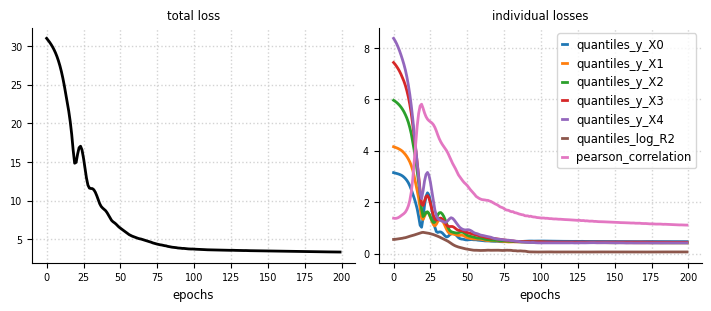

In [13]:
el.plots.loss(eliobj, figsize=(7,3))

### Expert expectations

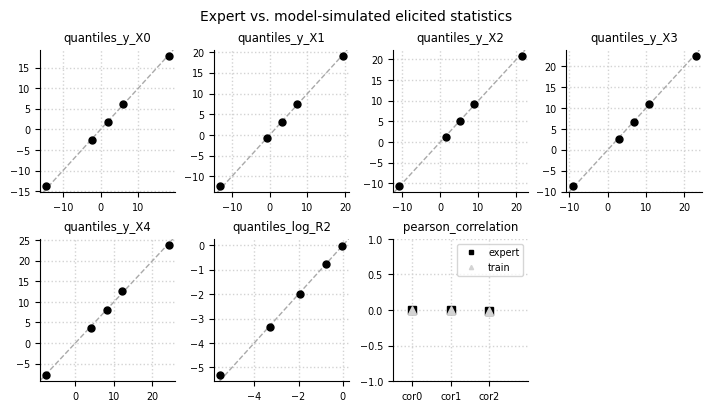

In [15]:
el.plots.elicits(eliobj, figsize=(7,4))

### Learned joint prior

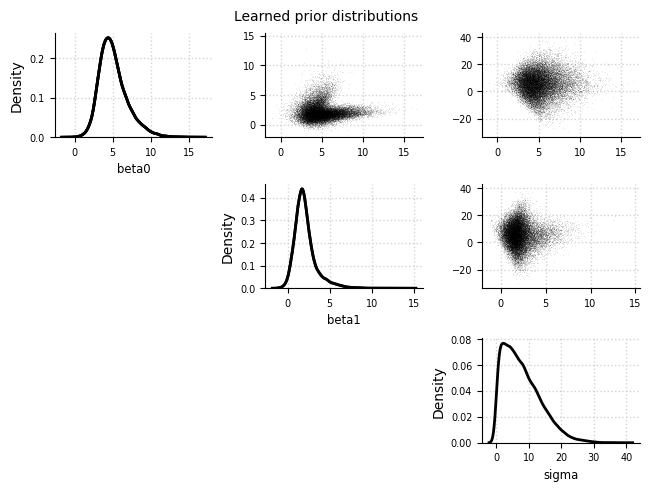

In [18]:
el.plots.priors(eliobj, constraints=dict(beta0=None,beta1=None,sigma="positive"))

## Add-on: Model averaging

ToDo